# Forest Land Area (percentage of total land area)
In this notebook we will predict forest land area based on social and governance readiness scores with inspiration from ND-GAIN indicators. 

Overview of the notebook structure
- Cleaning and assessing forest data 
- Log-transforming forest data
- Combining forest data with Predictor data
- Exploring correlations with the predictor data 
- Splitting the combined dataset in training, validation and testing data
    - With our outcome variable (forest) lagged by 5 years
- Fitting baseline model (mean model)
- Fitting simple mixed effects model (time, population)
- Fitting simple mixed effects models with each predictor seperately (time, population predictor_xyzab)
- Fitting theory driven mixed effects model of social (time, population, predictor_x, predictor_y, predictor_z)
- Fitting theory driven mixed effects model of governance (time, population, predictor_x, predictor_y, predictor_z)
- Fitting a mixed effects decision tree model, random forest with all predictors
- Compare model predictions 


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import seaborn as sns

import pickle as pkl

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [2]:
#Read file 
df = pd.read_csv('Data/forest_area_percent.csv', skiprows=4)


In [3]:

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 69 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1960            0 non-null      float64
 5   1961            0 non-null      float64
 6   1962            0 non-null      float64
 7   1963            0 non-null      float64
 8   1964            0 non-null      float64
 9   1965            0 non-null      float64
 10  1966            0 non-null      float64
 11  1967            0 non-null      float64
 12  1968            0 non-null      float64
 13  1969            0 non-null      float64
 14  1970            0 non-null      float64
 15  1971            0 non-null      float64
 16  1972            0 non-null      float64
 17  1973            0 non-null      flo

In [4]:

df.describe()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,Unnamed: 68
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31.862769,31.797279,31.754538,31.705921,31.656062,31.610967,31.563746,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22.971169,22.917186,22.899194,22.875540,22.852086,22.830212,22.808484,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.921508,11.923789,11.882564,11.832395,11.780793,11.682695,11.723177,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30.427988,30.582410,30.580166,30.334764,30.344393,30.308202,30.318655,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,45.911177,45.875123,45.962242,46.139633,46.319885,45.809650,45.698484,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,97.767115,97.694359,97.647564,97.569103,97.490577,97.412115,97.333611,NaN,NaN,NaN


In [5]:
summary = df.describe()

# Get the row corresponding to the count statistic
count_row = summary.loc['count']

# Filter for columns where the count is 0.0
columns_with_zero_count = count_row[count_row == 0.0].index.tolist()

print(columns_with_zero_count)

['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '2022', '2023', 'Unnamed: 68']


Seems like we only have values from 1990. So we are removing those columns. 

In [6]:
#Removing zero count columns from data
df_90 = df.drop(columns=columns_with_zero_count)

print(df_90)

                    Country Name Country Code                Indicator Name  \
0                          Aruba          ABW  Forest area (% of land area)   
1    Africa Eastern and Southern          AFE  Forest area (% of land area)   
2                    Afghanistan          AFG  Forest area (% of land area)   
3     Africa Western and Central          AFW  Forest area (% of land area)   
4                         Angola          AGO  Forest area (% of land area)   
..                           ...          ...                           ...   
261                       Kosovo          XKX  Forest area (% of land area)   
262                  Yemen, Rep.          YEM  Forest area (% of land area)   
263                 South Africa          ZAF  Forest area (% of land area)   
264                       Zambia          ZMB  Forest area (% of land area)   
265                     Zimbabwe          ZWE  Forest area (% of land area)   

     Indicator Code       1990       1991       199

In [64]:
df_90.describe()


,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
count,218.000000,222.000000,251.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,...,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000
mean,32.856441,33.554483,33.103147,33.002867,32.992832,32.944296,32.895509,32.846198,32.821598,32.772673,...,31.985581,31.942172,31.901776,31.862769,31.797279,31.754538,31.705921,31.656062,31.610967,31.563746
std,24.574032,24.986089,24.079624,23.913098,23.892300,23.833131,23.776234,23.721331,23.688899,23.637843,...,23.075606,23.034439,23.001998,22.971169,22.917186,22.899194,22.875540,22.852086,22.830212,22.808484
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.880879,12.914279,12.757912,12.675697,12.607303,12.538909,12.464662,12.402121,12.333727,12.287140,...,11.927941,11.812931,11.867219,11.921508,11.923789,11.882564,11.832395,11.780793,11.682695,11.723177
50%,29.842078,30.371049,31.218556,31.123515,31.316098,31.280093,31.579265,31.553551,31.489039,31.348927,...,30.319328,30.359705,30.367130,30.427988,30.582410,30.580166,30.334764,30.344393,30.308202,30.318655
75%,50.367952,52.181373,48.894391,48.263310,48.173347,48.107819,48.076107,47.714775,47.417713,47.484942,...,46.688549,46.079384,45.913536,45.911177,45.875123,45.962242,46.139633,46.319885,45.809650,45.698484
max,98.574551,98.550987,98.527423,98.503859,98.480295,98.456731,98.433167,98.409603,98.386038,98.362474,...,97.952462,97.890679,97.828897,97.767115,97.694359,97.647564,97.569103,97.490577,97.412115,97.333611


In [65]:

df_90.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 36 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1990            218 non-null    float64
 5   1991            222 non-null    float64
 6   1992            251 non-null    float64
 7   1993            254 non-null    float64
 8   1994            254 non-null    float64
 9   1995            254 non-null    float64
 10  1996            254 non-null    float64
 11  1997            254 non-null    float64
 12  1998            254 non-null    float64
 13  1999            254 non-null    float64
 14  2000            256 non-null    float64
 15  2001            256 non-null    float64
 16  2002            256 non-null    float64
 17  2003            256 non-null    flo

In [66]:
print(df_90)

                    Country Name Country Code                Indicator Name  \
0                          Aruba          ABW  Forest area (% of land area)   
1    Africa Eastern and Southern          AFE  Forest area (% of land area)   
2                    Afghanistan          AFG  Forest area (% of land area)   
3     Africa Western and Central          AFW  Forest area (% of land area)   
4                         Angola          AGO  Forest area (% of land area)   
..                           ...          ...                           ...   
261                       Kosovo          XKX  Forest area (% of land area)   
262                  Yemen, Rep.          YEM  Forest area (% of land area)   
263                 South Africa          ZAF  Forest area (% of land area)   
264                       Zambia          ZMB  Forest area (% of land area)   
265                     Zimbabwe          ZWE  Forest area (% of land area)   

     Indicator Code       1990       1991       199

In [8]:
#Removing non countries 

ISO_list = ['AFG', 'ALA', 'ALB', 'DZA', 'ASM', 'AND', 'AGO', 'AIA', 'ATA', 'ATG', 'ARG', 'ARM', 'ABW', 'AUS', 'AUT', 'AZE', 'BHS', 'BHR', 'BGD', 'BRB', 'BLR', 'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL', 'BES', 'BIH', 'BWA', 'BVT', 'BRA', 'IOT', 'BRN', 'BGR', 'BFA', 'BDI', 'CPV', 'KHM', 'CMR', 'CAN', 'CYM', 'CAF', 'TCD', 'CHL', 'CHN', 'CXR', 'CCK', 'COL', 'COM', 'COG', 'COD', 'COK', 'CRI', 'CIV', 'HRV', 'CUB', 'CUW', 'CYP', 'CZE', 'DNK', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'SLV', 'GNQ', 'ERI', 'EST', 'SWZ', 'ETH', 'FLK', 'FRO', 'FJI', 'FIN', 'FRA', 'GUF', 'PYF', 'ATF', 'GAB', 'GMB', 'GEO', 'DEU', 'GHA', 'GIB', 'GRC', 'GRL', 'GRD', 'GLP', 'GUM', 'GTM', 'GGY', 'GIN', 'GNB', 'GUY', 'HTI', 'HMD', 'VAT', 'HND', 'HKG', 'HUN', 'ISL', 'IND', 'IDN', 'IRN', 'IRQ', 'IRL', 'IMN', 'ISR', 'ITA', 'JAM', 'JPN', 'JEY', 'JOR', 'KAZ', 'KEN', 'KIR', 'PRK', 'KOR', 'KWT', 'KGZ', 'LAO', 'LVA', 'LBN', 'LSO', 'LBR', 'LBY', 'LIE', 'LTU', 'LUX', 'MAC', 'MDG', 'MWI', 'MYS', 'MDV', 'MLI', 'MLT', 'MHL', 'MTQ', 'MRT', 'MUS', 'MYT', 'MEX', 'FSM', 'MDA', 'MCO', 'MNG', 'MNE', 'MSR', 'MAR', 'MOZ', 'MMR', 'NAM', 'NRU', 'NPL', 'NLD', 'NCL', 'NZL', 'NIC', 'NER', 'NGA', 'NIU', 'NFK', 'MKD', 'MNP', 'NOR', 'OMN', 'PAK', 'PLW', 'PSE', 'PAN', 'PNG', 'PRY', 'PER', 'PHL', 'PCN', 'POL', 'PRT', 'PRI', 'QAT', 'REU', 'ROU', 'RUS', 'RWA', 'BLM', 'SHN', 'KNA', 'LCA', 'MAF', 'SPM', 'VCT', 'WSM', 'SMR', 'STP', 'SAU', 'SEN', 'SRB', 'SYC', 'SLE', 'SGP', 'SXM', 'SVK', 'SVN', 'SLB', 'SOM', 'ZAF', 'SGS', 'SSD', 'ESP', 'LKA', 'SDN', 'SUR', 'SJM', 'SWE', 'CHE', 'SYR', 'TWN', 'TJK', 'TZA', 'THA', 'TLS', 'TGO', 'TKL', 'TON', 'TTO', 'TUN', 'TUR', 'TKM', 'TCA', 'TUV', 'UGA', 'UKR', 'ARE', 'GBR', 'USA', 'UMI', 'URY', 'UZB', 'VUT', 'VEN', 'VNM', 'VGB', 'VIR', 'WLF', 'ESH', 'YEM', 'ZMB', 'ZWE']


df_iso = df_90[df_90['Country Code'].isin(ISO_list)]

print(df_iso)

     Country Name Country Code                Indicator Name  Indicator Code  \
0           Aruba          ABW  Forest area (% of land area)  AG.LND.FRST.ZS   
2     Afghanistan          AFG  Forest area (% of land area)  AG.LND.FRST.ZS   
4          Angola          AGO  Forest area (% of land area)  AG.LND.FRST.ZS   
5         Albania          ALB  Forest area (% of land area)  AG.LND.FRST.ZS   
6         Andorra          AND  Forest area (% of land area)  AG.LND.FRST.ZS   
..            ...          ...                           ...             ...   
260         Samoa          WSM  Forest area (% of land area)  AG.LND.FRST.ZS   
262   Yemen, Rep.          YEM  Forest area (% of land area)  AG.LND.FRST.ZS   
263  South Africa          ZAF  Forest area (% of land area)  AG.LND.FRST.ZS   
264        Zambia          ZMB  Forest area (% of land area)  AG.LND.FRST.ZS   
265      Zimbabwe          ZWE  Forest area (% of land area)  AG.LND.FRST.ZS   

          1990       1991       1992   

Make the wide df long instead

In [9]:
melted_df = pd.melt(df_iso, id_vars=['Country Code', 'Country Name', 'Indicator Name', 'Indicator Code'], var_name='Year', value_name='forest_area')

print(melted_df)

     Country Code  Country Name                Indicator Name  Indicator Code  \
0             ABW         Aruba  Forest area (% of land area)  AG.LND.FRST.ZS   
1             AFG   Afghanistan  Forest area (% of land area)  AG.LND.FRST.ZS   
2             AGO        Angola  Forest area (% of land area)  AG.LND.FRST.ZS   
3             ALB       Albania  Forest area (% of land area)  AG.LND.FRST.ZS   
4             AND       Andorra  Forest area (% of land area)  AG.LND.FRST.ZS   
...           ...           ...                           ...             ...   
6875          WSM         Samoa  Forest area (% of land area)  AG.LND.FRST.ZS   
6876          YEM   Yemen, Rep.  Forest area (% of land area)  AG.LND.FRST.ZS   
6877          ZAF  South Africa  Forest area (% of land area)  AG.LND.FRST.ZS   
6878          ZMB        Zambia  Forest area (% of land area)  AG.LND.FRST.ZS   
6879          ZWE      Zimbabwe  Forest area (% of land area)  AG.LND.FRST.ZS   

      Year  forest_area  
0

In [90]:
melted_df.info()
#year needs to be numeric

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6880 entries, 0 to 6879
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Code    6880 non-null   object 
 1   Country Name    6880 non-null   object 
 2   Indicator Name  6880 non-null   object 
 3   Indicator Code  6880 non-null   object 
 4   Year            6880 non-null   object 
 5   forest_area     6628 non-null   float64
dtypes: float64(1), object(5)
memory usage: 322.6+ KB


In [10]:
melted_df['Year'] = melted_df['Year'].astype(float)

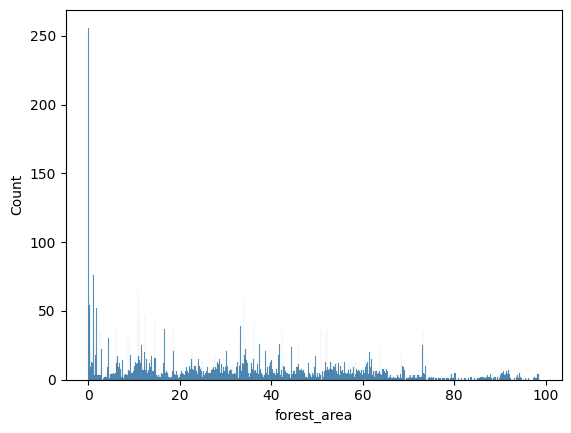

In [11]:
sns.histplot(data=melted_df, x='forest_area', binwidth=0.1)
plt.show()

We can see that we have countries that have 0 percent, which probably just is an indicator of not being able to record forest areas. 

In [12]:
#Making a list for all countries that have exactly 0.0 percent forest. 

zero_countries = melted_df.groupby('Country Code')['forest_area'].sum()

zero_countries = zero_countries[zero_countries == 0.0].index.tolist()

print(zero_countries)

['GIB', 'HKG', 'MAC', 'MCO', 'NRU', 'QAT']


In [13]:
#Removing zero count columns from data
#df_try = df_iso.drop(['Country Code'] == zero_countries)

forest = melted_df[~melted_df['Country Code'].isin(zero_countries)]

print(forest.groupby('Country Code')['forest_area'].sum())

Country Code
ABW      74.666667
AFG      59.289024
AGO    1898.615780
ALB     912.341971
AND    1089.361702
          ...     
WSM    1912.233864
YEM      33.274618
ZAF     463.685695
ZMB    2003.483116
ZWE    1498.262996
Name: forest_area, Length: 209, dtype: float64


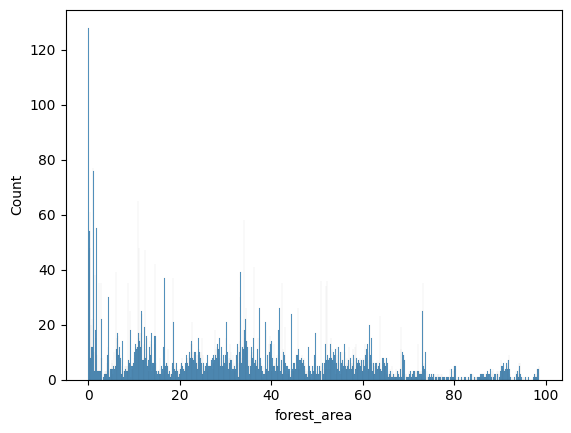

In [14]:
sns.histplot(data=forest, x='forest_area', binwidth=0.1)
plt.show()

We still do have a lot around 0, but no values of 0.0 anymore. Which means that the rest must be correct numbers.

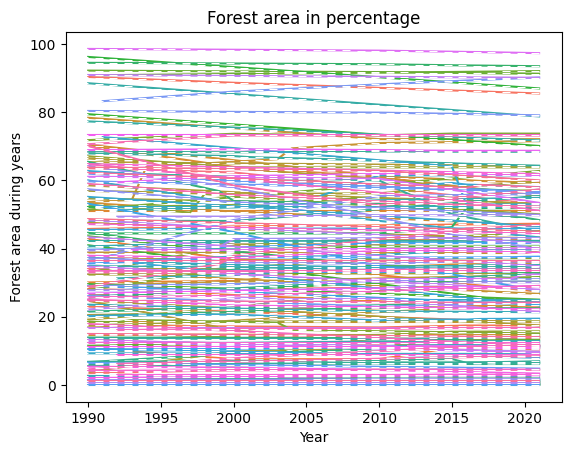

In [15]:
sns.lineplot(data=forest, x='Year', y='forest_area', hue='Country Name', marker=False, legend=False)

# Add title and labels
plt.title('Forest area in percentage')
plt.xlabel('Year')
plt.ylabel('Forest area during years')


# Show the plot
plt.show()

### Combine with predictor data 

In [16]:
#Read predictor file 

pred = pd.read_excel('predictor_data.xlsx')

print(pred)

                      Country Name Country Code  Year  Population, total  \
0                            Aruba          ABW  1960            54608.0   
1      Africa Eastern and Southern          AFE  1960        130692579.0   
2                      Afghanistan          AFG  1960          8622466.0   
3       Africa Western and Central          AFW  1960         97256290.0   
4                           Angola          AGO  1960          5357195.0   
...                            ...          ...   ...                ...   
17113        São Tomé and Principe          STP  2022                NaN   
17114                      Türkiye          TUR  2022                NaN   
17115                Taiwan, China          TWN  2022                NaN   
17116                      Vietnam          VNM  2022                NaN   
17117      Jersey, Channel Islands          JEY  2022                NaN   

       Land area (sq. km)    WGI VA    WGI PS    WGI GE    WGI RQ    WGI RL  \
0       

In [24]:
forest = forest.rename(columns={'Country Name':'Country'})
print(forest)

     Country Code       Country                Indicator Name  Indicator Code  \
0             ABW         Aruba  Forest area (% of land area)  AG.LND.FRST.ZS   
1             AFG   Afghanistan  Forest area (% of land area)  AG.LND.FRST.ZS   
2             AGO        Angola  Forest area (% of land area)  AG.LND.FRST.ZS   
3             ALB       Albania  Forest area (% of land area)  AG.LND.FRST.ZS   
4             AND       Andorra  Forest area (% of land area)  AG.LND.FRST.ZS   
...           ...           ...                           ...             ...   
6875          WSM         Samoa  Forest area (% of land area)  AG.LND.FRST.ZS   
6876          YEM   Yemen, Rep.  Forest area (% of land area)  AG.LND.FRST.ZS   
6877          ZAF  South Africa  Forest area (% of land area)  AG.LND.FRST.ZS   
6878          ZMB        Zambia  Forest area (% of land area)  AG.LND.FRST.ZS   
6879          ZWE      Zimbabwe  Forest area (% of land area)  AG.LND.FRST.ZS   

        Year  forest_area  

In [26]:
forest_full = pd.merge(forest, pred, on = ['Year', 'Country Code'], how = 'inner')
forest_full = forest_full.drop(columns=['Country'])

print(forest_full)
display(forest_full)

     Country Code                Indicator Name  Indicator Code    Year  \
0             ABW  Forest area (% of land area)  AG.LND.FRST.ZS  1990.0   
1             AFG  Forest area (% of land area)  AG.LND.FRST.ZS  1990.0   
2             AGO  Forest area (% of land area)  AG.LND.FRST.ZS  1990.0   
3             ALB  Forest area (% of land area)  AG.LND.FRST.ZS  1990.0   
4             AND  Forest area (% of land area)  AG.LND.FRST.ZS  1990.0   
...           ...                           ...             ...     ...   
6844          WSM  Forest area (% of land area)  AG.LND.FRST.ZS  2021.0   
6845          YEM  Forest area (% of land area)  AG.LND.FRST.ZS  2021.0   
6846          ZAF  Forest area (% of land area)  AG.LND.FRST.ZS  2021.0   
6847          ZMB  Forest area (% of land area)  AG.LND.FRST.ZS  2021.0   
6848          ZWE  Forest area (% of land area)  AG.LND.FRST.ZS  2021.0   

      forest_area  Country Name  Population, total  Land area (sq. km)  \
0        2.333333        

,Country Code,Indicator Name,Indicator Code,Year,forest_area,Country Name,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,Education,Innovation,Social Inequality,ICT
0,ABW,Forest area (% of land area),AG.LND.FRST.ZS,1990.0,2.333333,Aruba,65712.0,180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,Forest area (% of land area),AG.LND.FRST.ZS,1990.0,1.852782,Afghanistan,10694796.0,652230.0,NaN,NaN,NaN,NaN,NaN,NaN,2.46528,NaN,NaN,NaN
2,AGO,Forest area (% of land area),AG.LND.FRST.ZS,1990.0,63.578070,Angola,11828638.0,1246700.0,NaN,NaN,NaN,NaN,NaN,NaN,0.58071,NaN,NaN,NaN
3,ALB,Forest area (% of land area),AG.LND.FRST.ZS,1990.0,28.788321,Albania,3286542.0,27400.0,NaN,NaN,NaN,NaN,NaN,NaN,8.22387,NaN,NaN,NaN
4,AND,Forest area (% of land area),AG.LND.FRST.ZS,1990.0,34.042553,Andorra,53569.0,470.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6844,WSM,Forest area (% of land area),AG.LND.FRST.ZS,2021.0,57.982014,Samoa,218764.0,2780.0,0.747470,1.106232,0.377185,-0.219749,0.884038,0.592588,17.57185,1.0,NaN,11.685652
6845,YEM,Forest area (% of land area),AG.LND.FRST.ZS,2021.0,1.039832,"Yemen, Rep.",32981641.0,527970.0,-1.680930,-2.580310,-2.324521,-2.040683,-1.802895,-1.668239,NaN,20.0,NaN,16.988239
6846,ZAF,Forest area (% of land area),AG.LND.FRST.ZS,2021.0,14.025085,South Africa,59392255.0,1213090.0,0.770391,-0.750981,-0.071013,-0.090709,0.069080,-0.034114,25.23908,1804.0,NaN,58.085488
6847,ZMB,Forest area (% of land area),AG.LND.FRST.ZS,2021.0,60.030150,Zambia,19473125.0,743390.0,-0.369448,0.052348,-0.841102,-0.570348,-0.607838,-0.759728,NaN,13.0,NaN,34.908994


In [28]:
forest_full.describe()

,Year,forest_area,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,Education,Innovation,Social Inequality,ICT
count,6849.000000,6661.000000,6.688000e+03,6.500000e+03,4394.000000,4381.000000,4335.000000,4338.000000,4418.000000,4354.000000,3846.000000,3.105000e+03,1899.000000,3652.000000
mean,2005.599650,33.395135,3.142712e+07,6.315901e+05,-0.023932,-0.033829,-0.036949,-0.041109,-0.037296,-0.036512,33.528621,1.230694e+04,6.612796,38.994782
std,9.211116,24.528287,1.246897e+08,1.775174e+06,1.005664,0.986640,0.985730,0.985989,0.994267,1.000519,26.687615,7.595581e+04,2.048598,20.812439
min,1990.000000,0.000536,9.182000e+03,3.000000e+01,-2.313395,-3.312951,-2.439963,-2.547726,-2.590877,-1.936706,0.000000,1.000000e+00,0.900000,0.207817
25%,1998.000000,11.588901,7.889718e+05,1.487000e+04,-0.855547,-0.674156,-0.761935,-0.736130,-0.807197,-0.812046,10.432350,3.300000e+01,5.200000,21.796221
50%,2006.000000,32.208603,5.558200e+06,1.071600e+05,0.010354,0.051454,-0.174990,-0.161291,-0.188939,-0.264940,27.466045,2.240000e+02,6.900000,40.099212
75%,2014.000000,52.058824,1.981614e+07,4.727100e+05,0.899833,0.810646,0.644509,0.704074,0.769243,0.644892,52.342834,1.399000e+03,8.200000,56.024669
max,2021.000000,98.574551,1.412360e+09,1.638995e+07,1.800992,1.964211,2.469660,2.252235,2.124782,2.459118,150.201767,1.426644e+06,11.700000,108.336220


### Save combined data 

In [29]:
forest_full.to_csv('forest-modelling.csv', index=False)

# Modeling forest data 

In [46]:
forest_full = pd.read_csv('forest-modelling.csv')

forest_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6849 entries, 0 to 6848
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country Code        6849 non-null   object 
 1   Indicator Name      6849 non-null   object 
 2   Indicator Code      6849 non-null   object 
 3   Year                6849 non-null   float64
 4   forest_area         6661 non-null   float64
 5   Country Name        6849 non-null   object 
 6   Population, total   6688 non-null   float64
 7   Land area (sq. km)  6500 non-null   float64
 8   WGI VA              4394 non-null   float64
 9   WGI PS              4381 non-null   float64
 10  WGI GE              4335 non-null   float64
 11  WGI RQ              4338 non-null   float64
 12  WGI RL              4418 non-null   float64
 13  WGI CC              4354 non-null   float64
 14  Education           3846 non-null   float64
 15  Innovation          3105 non-null   float64
 16  Social

In [32]:
print(forest_full.isna().sum())

Country Code             0
Indicator Name           0
Indicator Code           0
Year                     0
forest_area            188
Country Name             0
Population, total      161
Land area (sq. km)     349
WGI VA                2455
WGI PS                2468
WGI GE                2514
WGI RQ                2511
WGI RL                2431
WGI CC                2495
Education             3003
Innovation            3744
Social Inequality     4950
ICT                   3197
dtype: int64


In [47]:
forest = forest_full.drop(columns=['ICT', 'Innovation'])

forest = forest.dropna()
print(forest)

     Country Code                Indicator Name  Indicator Code    Year  \
1257          ALB  Forest area (% of land area)  AG.LND.FRST.ZS  1996.0   
1265          AUT  Forest area (% of land area)  AG.LND.FRST.ZS  1996.0   
1280          BRA  Forest area (% of land area)  AG.LND.FRST.ZS  1996.0   
1286          CAN  Forest area (% of land area)  AG.LND.FRST.ZS  1996.0   
1288          CHL  Forest area (% of land area)  AG.LND.FRST.ZS  1996.0   
...           ...                           ...             ...     ...   
6813          SWE  Forest area (% of land area)  AG.LND.FRST.ZS  2021.0   
6821          THA  Forest area (% of land area)  AG.LND.FRST.ZS  2021.0   
6827          TUN  Forest area (% of land area)  AG.LND.FRST.ZS  2021.0   
6834          URY  Forest area (% of land area)  AG.LND.FRST.ZS  2021.0   
6835          USA  Forest area (% of land area)  AG.LND.FRST.ZS  2021.0   

      forest_area   Country Name  Population, total  Land area (sq. km)  \
1257    28.361314       

In [49]:
countries_without_nans = forest.dropna(subset=forest.columns, how='any')['Country Code'].unique()

len(countries_without_nans)

134

In [50]:
len(forest['Country Code'].unique())

forest.describe()

,Year,forest_area,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,Education,Social Inequality
count,1228.000000,1228.000000,1.228000e+03,1.228000e+03,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000
mean,2011.052117,31.589070,5.926650e+07,1.067069e+06,0.384096,0.106379,0.425366,0.463525,0.319351,0.300858,52.597148,6.941775
std,6.346081,19.363088,1.928120e+08,2.713946e+06,0.913825,0.864469,0.935872,0.890138,0.999573,1.058701,25.656362,1.889426
min,1996.000000,0.045186,4.472800e+04,1.800000e+02,-1.833387,-2.810035,-2.336034,-2.242906,-1.976794,-1.759068,0.456960,1.600000
25%,2006.000000,13.053363,4.005037e+06,4.808000e+04,-0.233657,-0.472843,-0.348622,-0.245562,-0.537161,-0.562483,34.835217,5.700000
50%,2012.000000,31.474027,9.511978e+06,1.750200e+05,0.490304,0.207683,0.328050,0.472256,0.212978,0.038138,55.439854,7.100000
75%,2016.000000,45.014950,4.417752e+07,5.475570e+05,1.139616,0.802297,1.210805,1.216194,1.178231,1.197882,70.943386,8.400000
max,2021.000000,80.216075,1.411100e+09,1.638139e+07,1.800992,1.720112,2.347191,2.039989,2.124782,2.459118,150.201767,10.500000


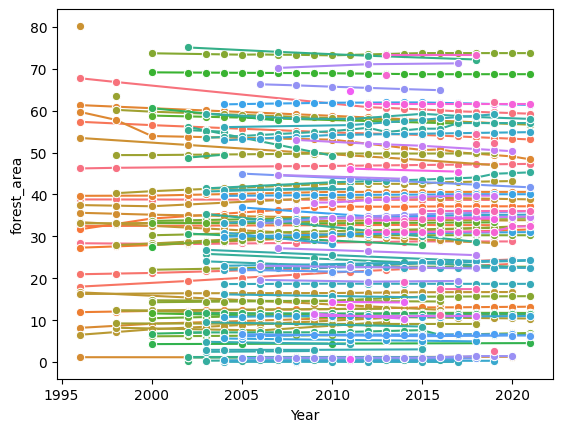

In [52]:
sns.lineplot(data=forest, x='Year', y='forest_area', hue='Country Code', marker='o', legend=False)

# Add title and labels
#plt.title('Log Transformed Time Series Data')
#plt.xlabel('Year')
#plt.ylabel('Log Transformed Value')

# Show the plot
plt.show()

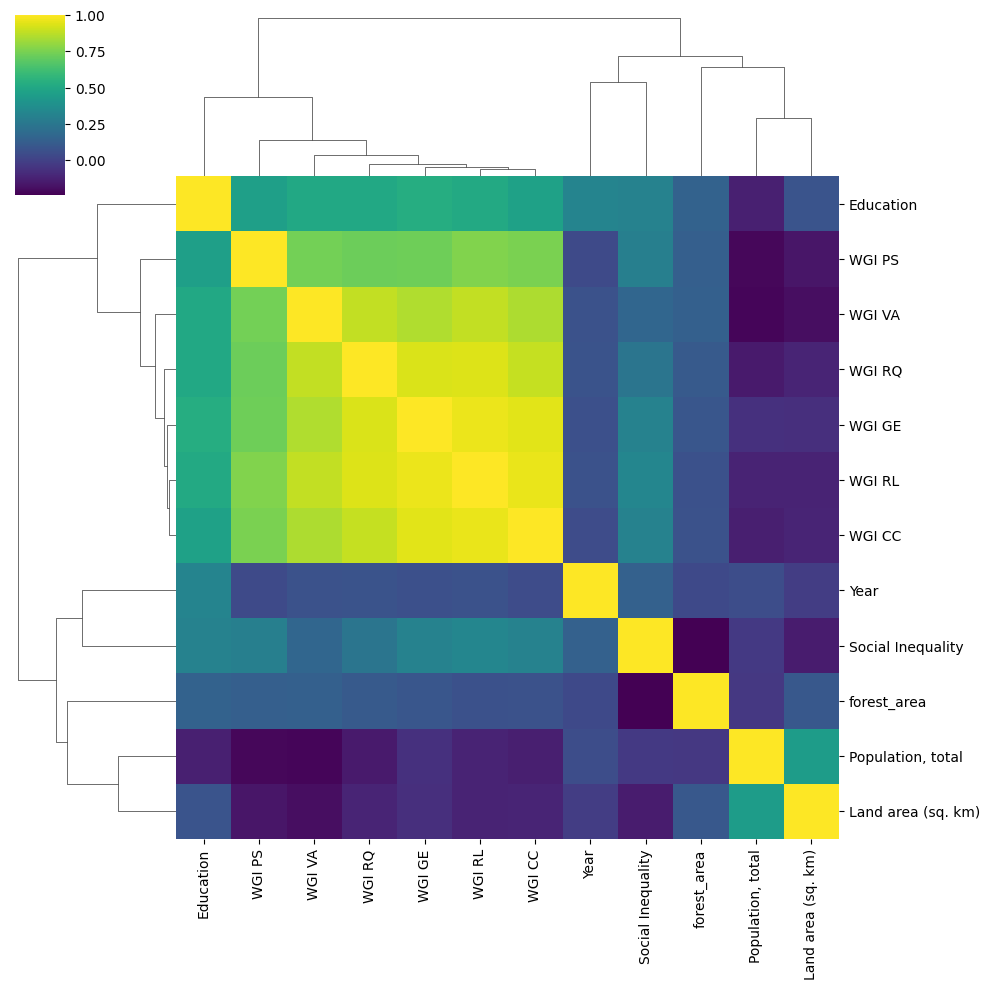

In [53]:
forest_num = forest[forest.select_dtypes(exclude=['object']).columns]

sns.clustermap(forest_num.corr(), cmap='viridis')
plt.show()